[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/moshi4/pyCirclize/blob/main/docs/plot_tips.ipynb)

In [1]:
# %pip install pycirclize

## Subplots

pyCirclize supports plotting to user-defined Polar Axes. Users can target subplot Polar Axes with the `circos.plotfig()` method to combine them with other plots.

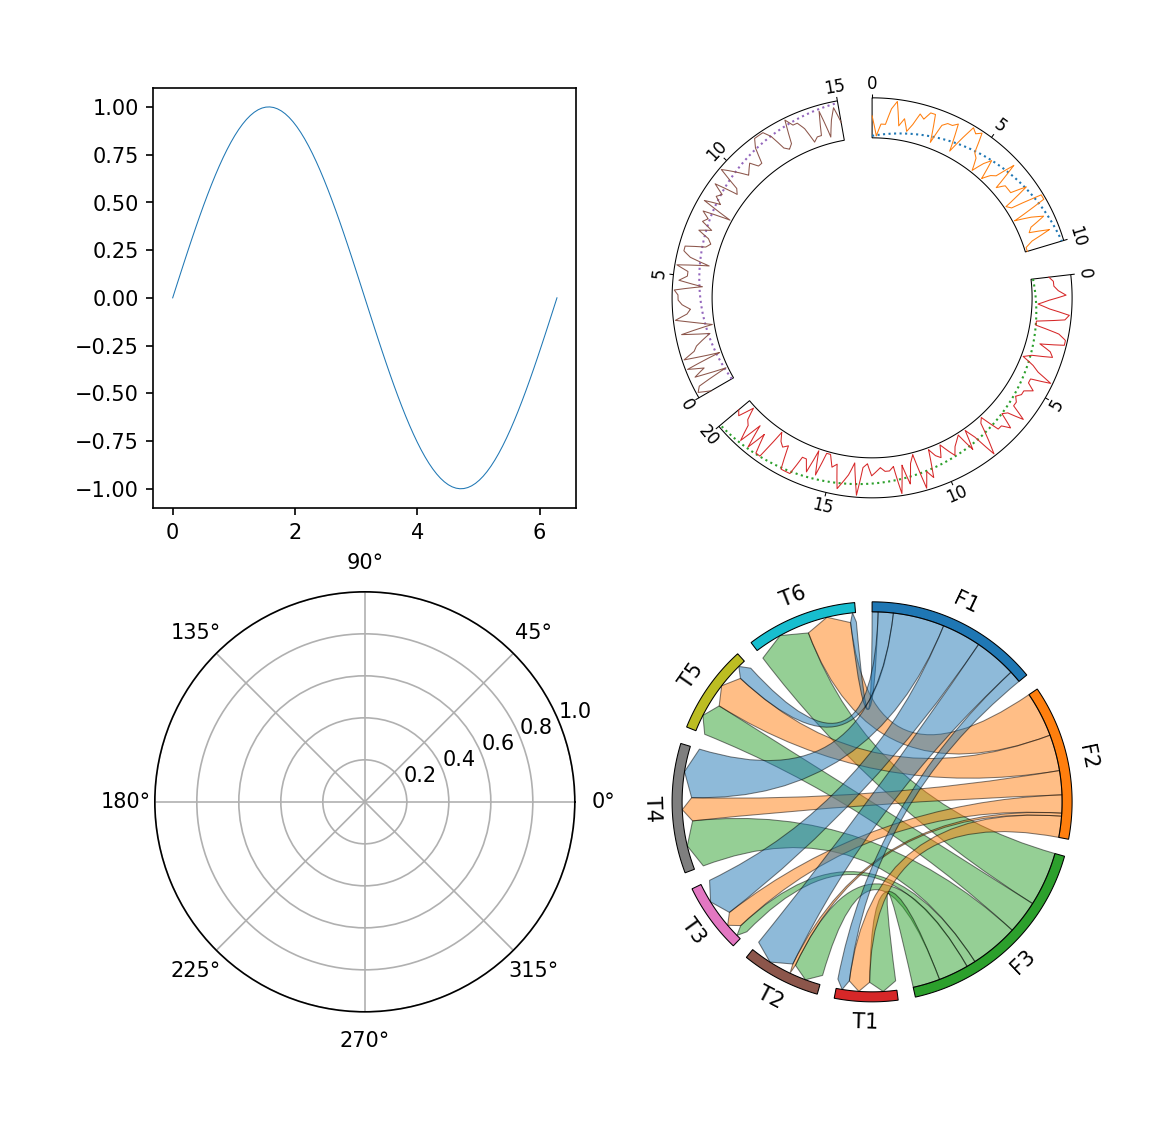

In [2]:
from pycirclize import Circos
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(0)

# Create 4 subplots
fig = plt.figure(figsize=(8, 8), dpi=150)
ax1 = fig.add_subplot(221)
polar_ax2 = fig.add_subplot(222, polar=True)
polar_ax3 = fig.add_subplot(223, polar=True)
polar_ax4 = fig.add_subplot(224, polar=True)

# Plot to first subplot (ax1)
x = np.linspace(0, 2 * np.pi, 100)
ax1.plot(x, np.sin(x))

# Plot circos to second subplot (polar_ax2)
sectors = {"A": 10, "B": 20, "C": 15}
circos = Circos(sectors, space=10)
for sector in circos.sectors:
    track = sector.add_track((80, 100), r_pad_ratio=0.1)
    track.axis()
    track.xticks_by_interval(5)
    vmin, vmax = 0, 10
    # Line between start-end two points
    track.line([track.start, track.end], [vmin, vmax], lw=1, ls="dotted")
    # Line of random value points
    x = np.linspace(track.start, track.end, int(track.size) * 5 + 1)
    y = np.random.randint(vmin, vmax, len(x))
    track.line(x, y)

fig = circos.plotfig(ax=polar_ax2)

# Plot chord diagram to fourth subplot (polar_ax4)
row_names = ["F1", "F2", "F3"]
col_names = ["T1", "T2", "T3", "T4", "T5", "T6"]
matrix_data = [
    [4, 14, 13, 17, 5, 2],
    [7, 1, 6, 8, 12, 15],
    [9, 10, 3, 16, 11, 18],
]
matrix_df = pd.DataFrame(matrix_data, index=row_names, columns=col_names)

circos = Circos.chord_diagram(
    matrix_df,
    r_lim=(95, 100),
    space=5,
    cmap="tab10",
    link_kws=dict(ec="black", lw=0.5, direction=1),
)
fig = circos.plotfig(ax=polar_ax4)

## Grouping Sectors

In pyCirclize, the space size between sectors can be set arbitrarily. 
By using the `calc_group_spaces` function, users can easily get the sector space size setting 
within/between groups based on the number of groups.
Groups can be explicitly visualized as shown in the code example below.

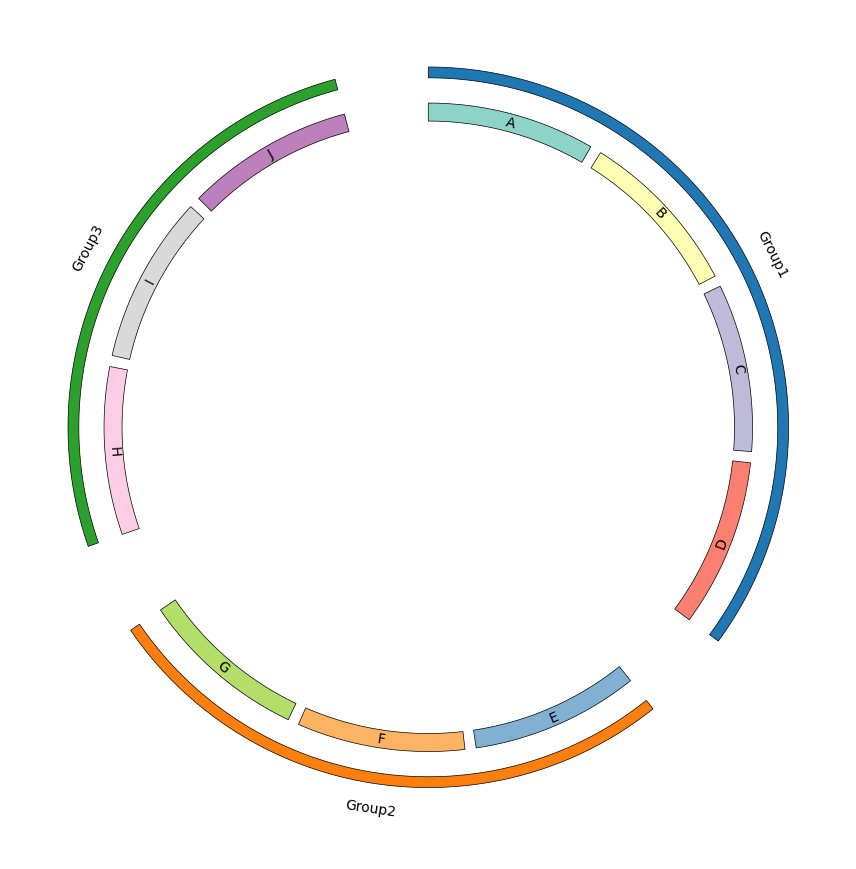

In [3]:
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler

sectors = {name: 10 for name in "ABCDEFGHIJ"}
group1, group2, group3 = list("ABCD"), list("EFG"), list("HIJ")

# Calculate appropriate group between/within spaces
# In this example, 10 sectors are displayed as groups dividied into [4, 3, 3]
spaces = calc_group_spaces([4, 3, 3], space_bw_group=15, space_in_group=2)
circos = Circos(sectors, space=spaces)

# Plot sector track
ColorCycler.set_cmap("Set3")
for sector in circos.sectors:
    track = sector.add_track(r_lim=(85, 90))
    track.axis(fc=ColorCycler())
    track.text(sector.name)

# Plot group sectors range
ColorCycler.set_cmap("tab10")
for idx, group in enumerate((group1, group2, group3), 1):
    group_deg_lim = circos.get_group_sectors_deg_lim(group)
    circos.rect(r_lim=(97, 100), deg_lim=group_deg_lim, fc=ColorCycler(), ec="black", lw=0.5)
    group_center_deg = sum(group_deg_lim) / 2
    circos.text(f"Group{idx}", r=105, deg=group_center_deg, adjust_rotation=True)

fig = circos.plotfig()

## Annotation Overlap

In data visualization, labels often overlap each other and interfere with data interpretation.
pyCirclize implements a simple algorithm to automatically adjust label positions so that annotation labels plotted with `track.annotate()` do not overlap.

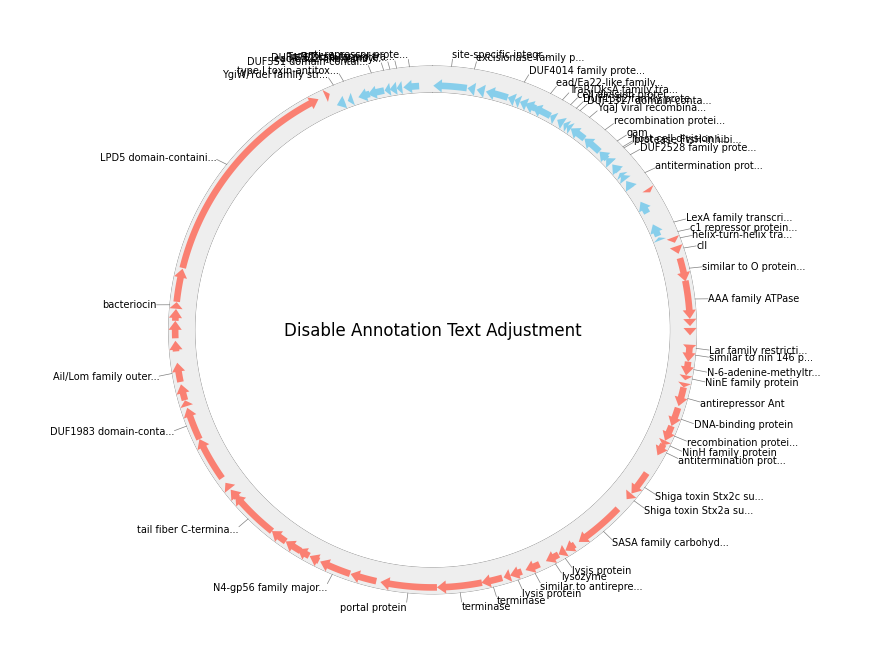

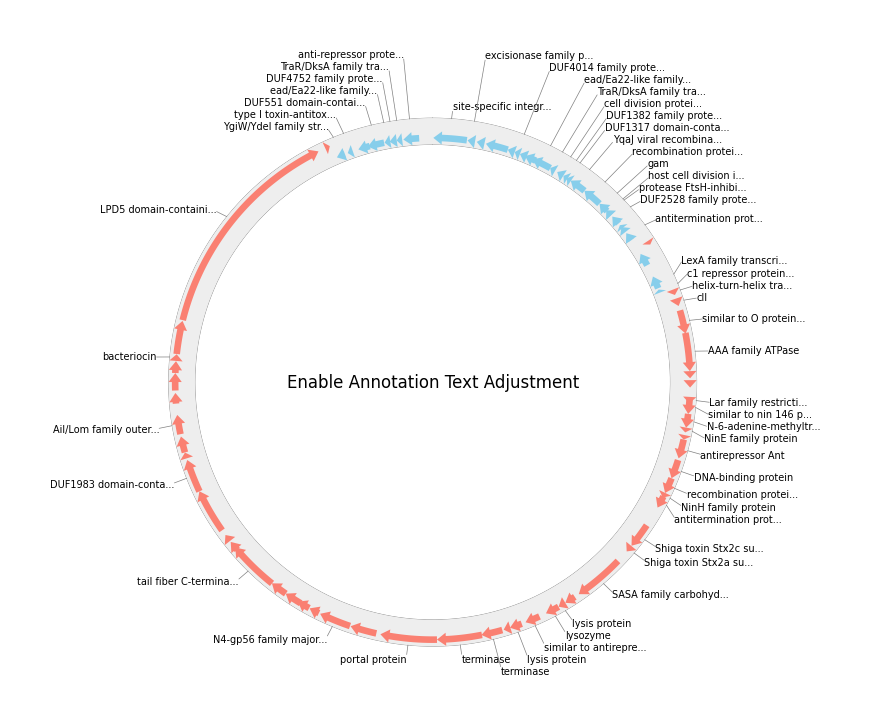

In [1]:
from pycirclize import Circos, config
from pycirclize.parser import Gff
from pycirclize.utils import load_prokaryote_example_file

gff_file = load_prokaryote_example_file("enterobacteria_phage.gff")
gff = Gff(gff_file)

seqid2size = gff.get_seqid2size()
space = 0 if len(seqid2size) == 1 else 2
circos = Circos(sectors=seqid2size, space=space)

seqid2features = gff.get_seqid2features(feature_type="CDS")
for sector in circos.sectors:
    cds_track = sector.add_track((90, 100))
    cds_track.axis(fc="#EEEEEE", ec="none")
    cds_track.grid(2, color="black")

    features = seqid2features[sector.name]
    for feature in features:
        # Plot CDS feature
        if feature.location.strand == 1:
            cds_track.genomic_features(feature, plotstyle="arrow", r_lim=(95, 100), fc="salmon")
        else:
            cds_track.genomic_features(feature, plotstyle="arrow", r_lim=(90, 95), fc="skyblue")
        # Plot feature annotation label
        start, end = int(feature.location.start), int(feature.location.end)
        label_pos = (start + end) / 2
        label = feature.qualifiers.get("product", [""])[0]
        if label == "" or label.startswith("hypothetical"):
            continue
        cds_track.annotate(label_pos, label, label_size=7)

# Disable annotation text adjustment
config.ann_adjust.enable = False
fig = circos.plotfig()
_ = circos.ax.text(0, 0, "Disable Annotation Text Adjustment", size=12, va="center", ha="center")

# Enable annotation text adjustment (Default)
config.ann_adjust.enable = True
fig = circos.plotfig()
_ = circos.ax.text(0, 0, "Enable Annotation Text Adjustment", size=12, va="center", ha="center")

## Anti-clockwise

pyCirclize sets the coordinate direction of each sector as clockwise by default.
Users can set the coordinate direction of any sector to anti-clockwise with 
`sector2clockwise` option when initializing Circos instance.

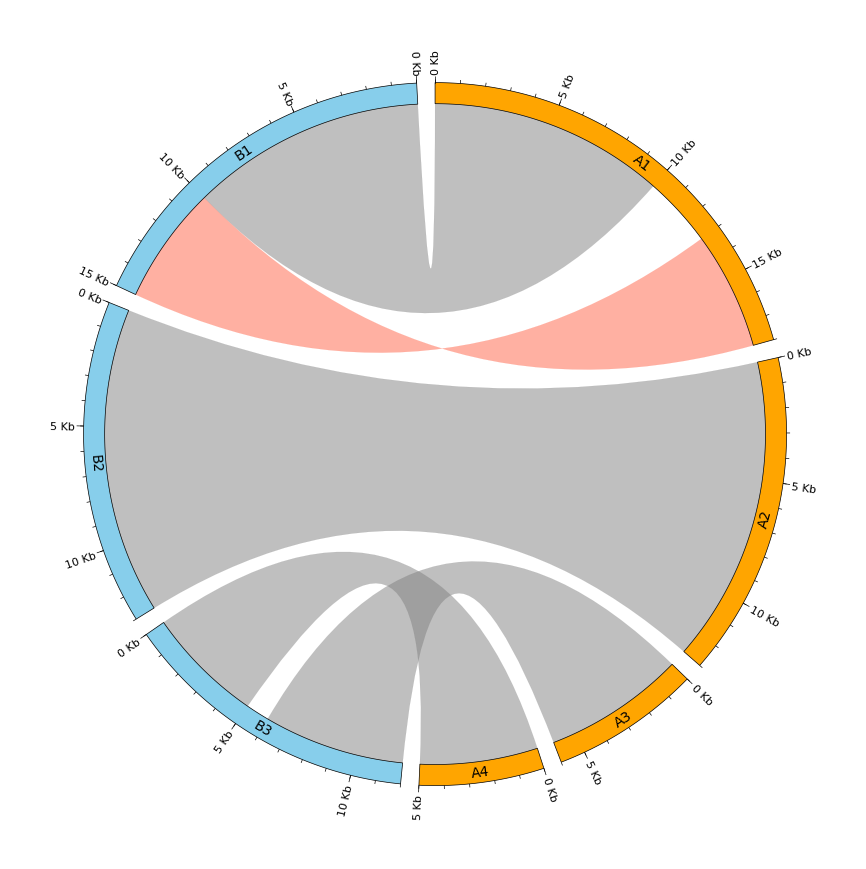

In [4]:
from pycirclize import Circos

sectors = dict(A1=18000, A2=13000, A3=6000, A4=5000, B3=12000, B2=13000, B1=15000)
circos = Circos(
    sectors,
    space=3,
    # Set (B1, B2, B3) sector coordinate direction as anti-clockwise
    sector2clockwise=dict(B1=False, B2=False, B3=False),
)

for sector in circos.sectors:
    # Plot track
    color = "orange" if sector.name.startswith("A") else "skyblue"
    track = sector.add_track((94, 100), r_pad_ratio=0.1)
    track.axis(fc=color)
    track.text(sector.name)
    # Plot xticks
    major_interval, minor_interval = 5000, 1000
    track.xticks_by_interval(major_interval, label_orientation="vertical", label_formatter=lambda v: f"{v / 1000:.0f} Kb")
    track.xticks_by_interval(minor_interval, tick_length=1, show_label=False)

# Plot links
circos.link(("A1", 0, 10000), ("B1", 0, 10000))
circos.link(("A1", 18000, 13000), ("B1", 10000, 15000), color="tomato")
circos.link(("A2", 0, 13000), ("B2", 0, 13000))
circos.link(("A3", 0, 6000), ("B3", 6000, 12000))
circos.link(("A4", 0, 5000), ("B3", 0, 5000))

fig = circos.plotfig()

## Colorbar

Users can easily plot colorbars with `circos.colorbar()` method.

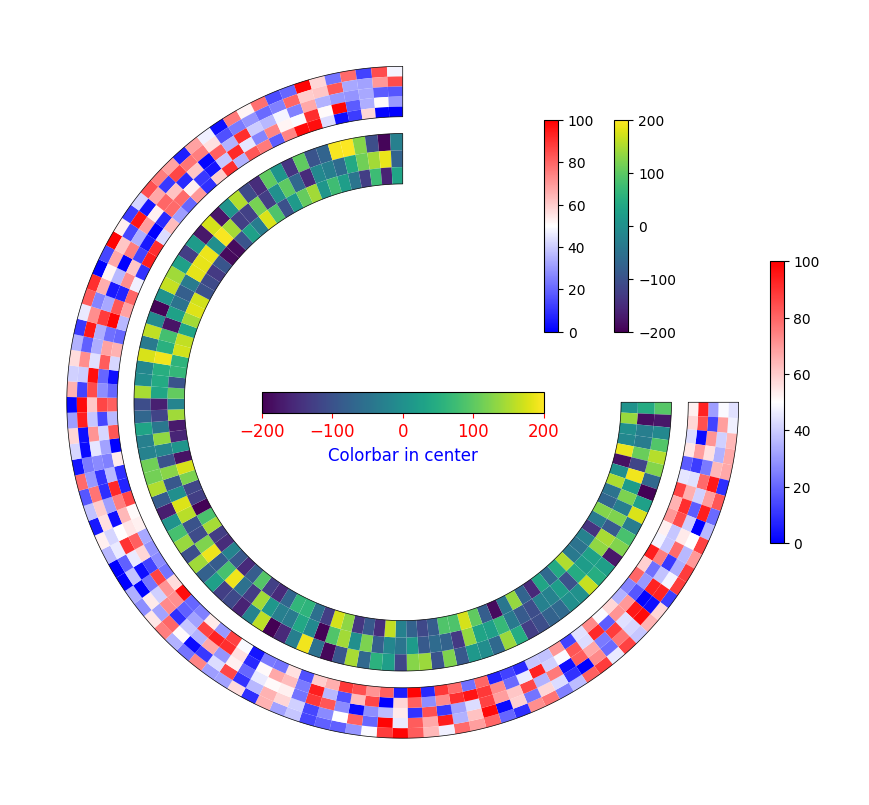

In [5]:
from pycirclize import Circos
import numpy as np
np.random.seed(0)

# Initialize Circos instance
circos = Circos(sectors=dict(data=100), start=90)
sector = circos.sectors[0]

# Plot heatmap track1 (cmap="bwr")
track1 = sector.add_track((85, 100))
track1.axis()
vmin1, vmax1, cmap1 = 0, 100, "bwr"
matrix1 = np.random.randint(vmin1, vmax1, (5, 100))
track1.heatmap(matrix1, cmap=cmap1, vmin=vmin1, vmax=vmax1)

# Plot heatmap track2 (cmap="viridis")
track2 = sector.add_track((65, 80))
track2.axis()
vmin2, vmax2, cmap2 = -200, 200, "viridis"
matrix2 = np.random.randint(vmin2, vmax2, (3, 100))
track2.heatmap(matrix2, cmap=cmap2, vmin=vmin2, vmax=vmax2)

# Plot colorbar in various style
# bounds = (x, y, width, height)
circos.colorbar(vmin=vmin1, vmax=vmax1)
circos.colorbar(bounds=(0.7, 0.6, 0.02, 0.3), vmin=vmin1, vmax=vmax1, cmap="bwr")
circos.colorbar(bounds=(0.8, 0.6, 0.02, 0.3), vmin=vmin2, vmax=vmax2, cmap="viridis")
circos.colorbar(
    bounds=(0.3, 0.485, 0.4, 0.03),
    vmin=vmin2,
    vmax=vmax2,
    cmap="viridis",
    orientation="horizontal",
    label="Colorbar in center",
    label_kws=dict(size=12, color="blue"),
    tick_kws=dict(labelsize=12, colors="red"),
)

fig = circos.plotfig()

## Legend

Example of manual legend plotting code using [`Axes.legend()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html) method.  
See [Legend guide](https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html) for more details.

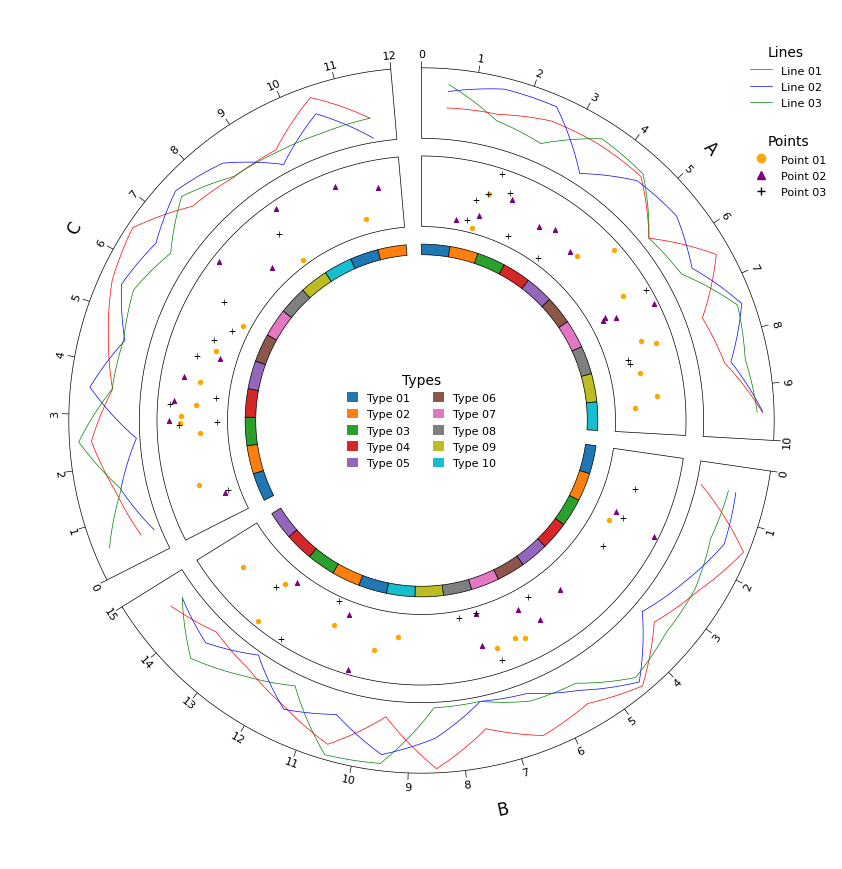

In [6]:
from pycirclize import Circos
from pycirclize.utils import ColorCycler
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
np.random.seed(0)

line_colors = ("red", "blue", "green")
scatter_colors = ("orange", "purple", "black")
scatter_markers = ("o", "^", "+")
cmap_name = "tab10"

sectors = dict(A=10, B=15, C=12)
circos = Circos(sectors, space=5)
for sector in circos.sectors:
    sector.text(sector.name, r=110, size=12)
    # Plot line track
    track1 = sector.add_track((80, 100), r_pad_ratio=0.1)
    track1.axis()
    track1.xticks_by_interval(interval=1)
    for line_color in line_colors:
        x = np.arange(sector.start, sector.end) + 0.5
        y = np.random.randint(0, 100, len(x))
        track1.line(x, y, vmax=100, color=line_color)
    # Plot scatter track
    track2 = sector.add_track((55, 75), r_pad_ratio=0.1)
    track2.axis()
    for color, marker in zip(scatter_colors, scatter_markers):
        point_num = 10
        x = np.random.rand(point_num) * (sector.end - 1) + 0.5
        y = np.random.rand(point_num) * 10
        track2.scatter(x, y, vmax=10, c=color, marker=marker, s=15)
    # Plot rect track
    track3 = sector.add_track((47, 50))
    ColorCycler.set_cmap(cmap_name)
    for idx in range(int(sector.start), int(sector.end)):
        track3.rect(idx, idx + 1, color=ColorCycler(), ec="black", lw=0.5)

fig = circos.plotfig()

# Plot legend
line_handles = [
    Line2D([], [], color="red", label="Line 01"),
    Line2D([], [], color="blue", label="Line 02"),
    Line2D([], [], color="green", label="Line 03"),
]
line_legend = circos.ax.legend(
    handles=line_handles,
    bbox_to_anchor=(0.93, 1.02),
    fontsize=8,
    title="Lines",
    handlelength=2,
)
circos.ax.add_artist(line_legend)

scatter_handles = [
    # Marker List: https://matplotlib.org/stable/api/markers_api.html
    Line2D([], [], color="orange", marker="o", label="Point 01", ms=6, ls="None"),
    Line2D([], [], color="purple", marker="^", label="Point 02", ms=6, ls="None"),
    Line2D([], [], color="black", marker="+", label="Point 03", ms=6, ls="None"),
]
scatter_legend = circos.ax.legend(
    handles=scatter_handles,
    bbox_to_anchor=(0.93, 0.90),
    fontsize=8,
    title="Points",
    handlelength=2,
)
circos.ax.add_artist(scatter_legend)

rect_handles = []
rect_colors = ColorCycler.get_color_list()
for idx, color in enumerate(rect_colors, 1):
    rect_handles.append(Patch(color=color, label=f"Type {idx:02d}"))
_ = circos.ax.legend(
    handles=rect_handles,
    bbox_to_anchor=(0.5, 0.5),
    loc="center",
    fontsize=8,
    title="Types",
    ncol=2,
)

# *** To save a figure with legend as a file, use `fig.savefig()` method ***
# *** `circos.savefig()` method does not save the figure with legend ***
# fig.savefig("result.png", dpi=100)

## Stacked Bar

Users can easily plot stacked bar chart from matrix dataframe with row and column names.
Vertical and horizontal stacked bar chart can be plotted using `track.stacked_bar()` and `track.stacked_barh()` methods, respectively.

     group0  group1  group2  group3  group4  group5
R0       17      10       5       8      16       8
R1       12      14       8      10       7       9
R2       12      11      13      13      17      15
R3        6      11      12      12      19      13
R4        6      10      14      18      13      14
R5        9       8       5       8      10      19
R6        5       7       8      13       6       8
R7       18       8       8      19      12       5
R8        6      14      14       5      15       9
R9       12       8      19      16       7      12
R10      17       7       5       5       9      10
R11      10      11      13       9       6       9


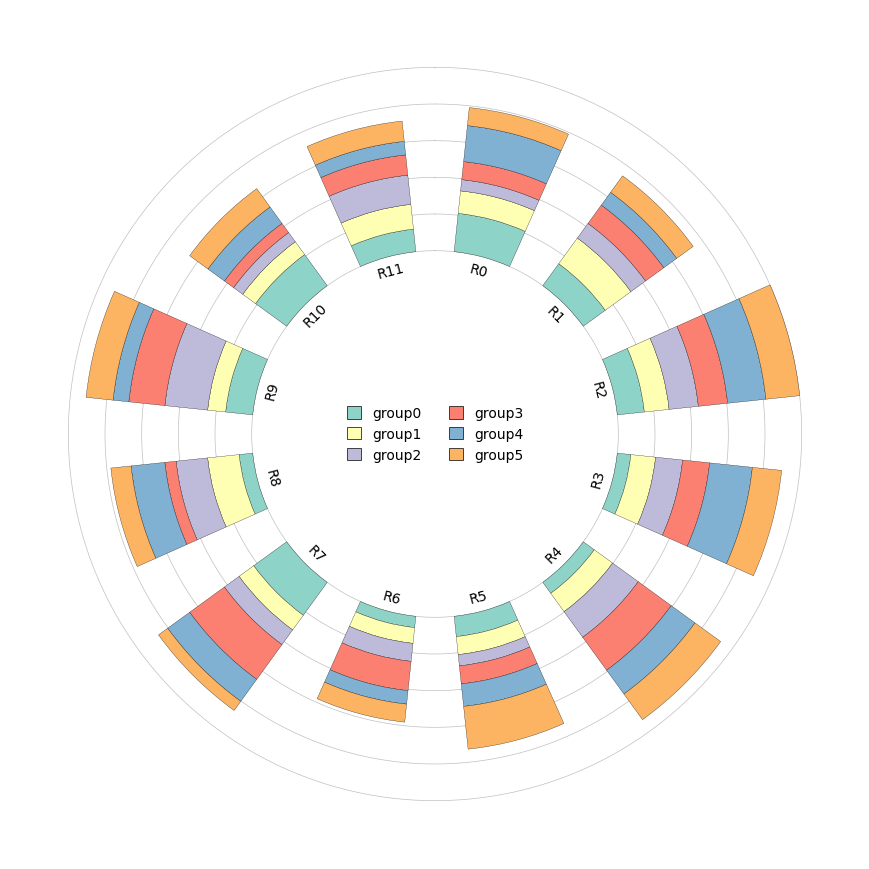

In [7]:
from pycirclize import Circos
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
np.random.seed(0)

# Generate matrix data for stacked bar plot
row_num, col_num = 12, 6
matrix = np.random.randint(5, 20, (row_num, col_num))
row_names = [f"R{i}" for i in range(row_num)]
col_names = [f"group{i}" for i in range(col_num)]
table_df = pd.DataFrame(matrix, index=row_names, columns=col_names)
print(table_df)

# Initialize Circos sector & track
circos = Circos(sectors=dict(bar=len(table_df.index)))
sector = circos.sectors[0]
track = sector.add_track((50, 100))
track.grid()

# Plot stacked bar
colormap = "Set3"
sb_table = track.stacked_bar(
    table_df,
    width=0.6,
    cmap=colormap,
    bar_kws=dict(ec="black", lw=0.2),
    label_pos="bottom",
    label_kws=dict(size=10, orientation="horizontal"),
)

fig = circos.plotfig()

# Plot legends
col_name2color = sb_table.get_col_name2color(colormap)
_ = circos.ax.legend(
    handles=[Patch(label=n, fc=c, ec="black", lw=0.5) for n, c in col_name2color.items()],
    bbox_to_anchor=(0.5, 0.5),
    loc="center",
    ncols=2,
)

# fig.savefig("stacked_bar.png")

   group1  group2  group3  group4  group5  group6
A      17      10       5       8      16       8
B      12      14       8      10       7       9
C      12      11      13      13      17      15
D       6      11      12      12      19      13
E       6      10      14      18      13      14
F       9       8       5       8      10      19


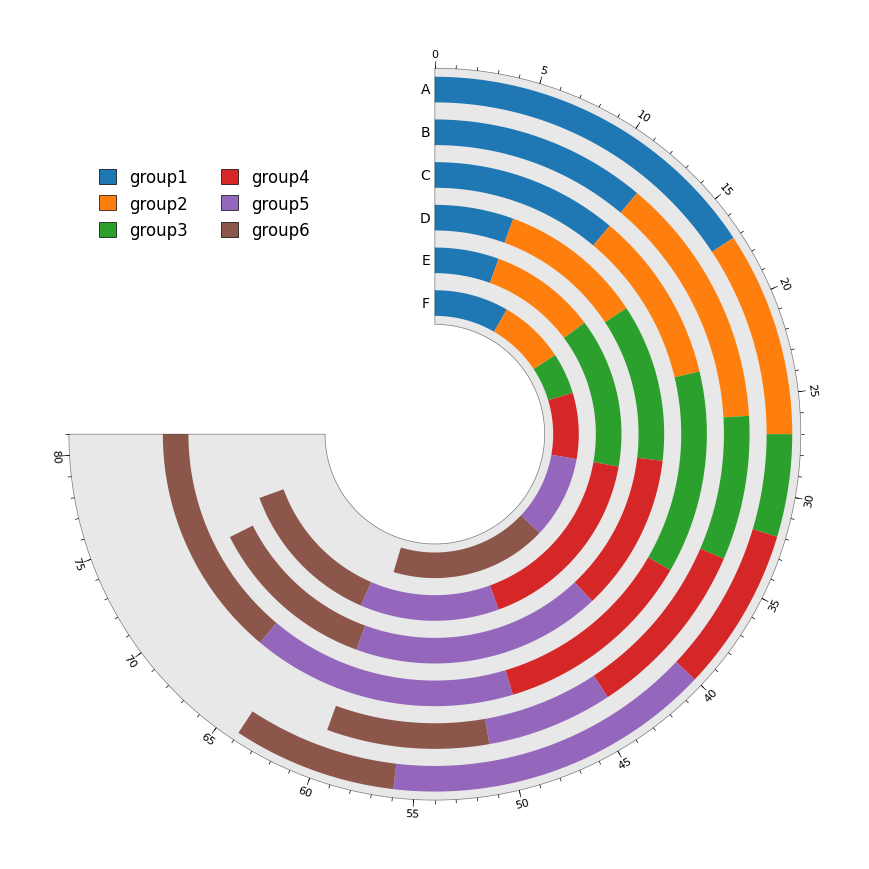

In [8]:
from pycirclize import Circos
from pycirclize.parser import StackedBarTable
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
np.random.seed(0)

# Generate & load matrix data for horizontal stacked bar plot
row_names = list("ABCDEF")
col_names = ["group1", "group2", "group3", "group4", "group5", "group6"]
matrix = np.random.randint(5, 20, (len(row_names), len(col_names)))
table_df = pd.DataFrame(matrix, index=row_names, columns=col_names)
sb_table = StackedBarTable(table_df)
print(table_df)

# Initialize Circos sector & track (0 <= range <= 270)
circos = Circos(sectors=dict(bar=sb_table.row_sum_vmax), start=0, end=270)
sector = circos.sectors[0]
track = sector.add_track((30, 100))
track.axis(fc="lightgrey", ec="black", alpha=0.5)

# Plot horizontal stacked bar & label & xticks
colormap = "tab10"
track.stacked_barh(sb_table.dataframe, cmap=colormap, width=0.6)
label_r_list = sb_table.calc_barh_label_r_list(track.r_plot_lim)
for label_r, row_name in zip(label_r_list, sb_table.row_names):
    track.text(f"{row_name} ", x=0, r=label_r, ha="right")
track.xticks_by_interval(interval=5)
track.xticks_by_interval(interval=1, tick_length=1, show_label=False)

fig = circos.plotfig()

# Plot legends
col_name2color = sb_table.get_col_name2color(colormap)
_ = circos.ax.legend(
    handles=[Patch(label=n, fc=c, ec="black", lw=0.5) for n, c in col_name2color.items()],
    bbox_to_anchor=(0.2, 0.8),
    fontsize=12,
    loc="center",
    ncols=2,
)

# fig.savefig("stacked_barh.png")

## Appendix

### 1. Clock

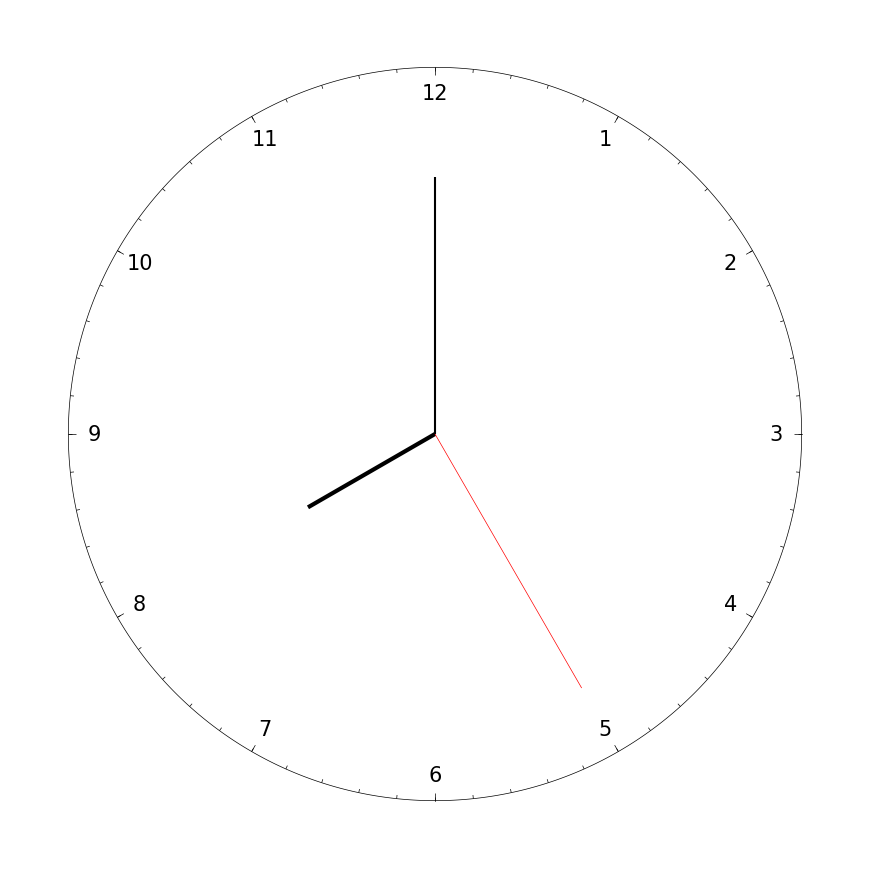

In [9]:
from pycirclize import Circos
import numpy as np

circos = Circos(sectors={"clock": 12})
sector = circos.sectors[0]

# Plot outer line & xticks
track = sector.add_track(r_lim=(100, 100))
major_xticks = np.arange(0, 12, 1) + 1
track.xticks(major_xticks, outer=False, show_bottom_line=True)
minor_xticks = np.arange(0, 12, 0.2)
track.xticks(minor_xticks, outer=False, tick_length=1)

# Plot 1-12 hour characters
for x in major_xticks:
    track.text(str(x), x=x, r=93, size=15, adjust_rotation=False)

# Plot clock hands (hour, minute, second)
sector.line(r=(0, 40), start=8, end=8, lw=3)
sector.line(r=(0, 70), start=0, end=0, lw=1.5)
sector.line(r=(0, 80), start=5, end=5, lw=0.5, color="red")

fig = circos.plotfig()

### 2. Dartboard

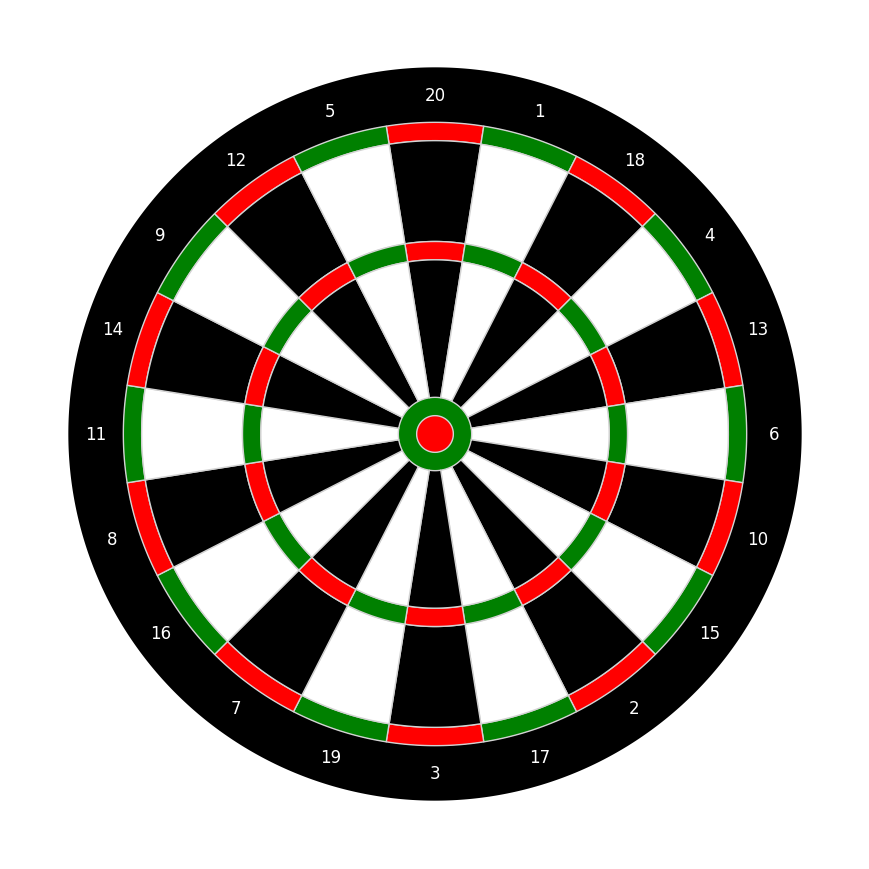

In [10]:
from pycirclize import Circos

points = [20, 1, 18, 4, 13, 6, 10, 15, 2, 17, 3, 19, 7, 16, 8, 11, 14, 9, 12, 5]
sectors = {str(p): 1 for p in points}
circos = Circos(sectors, space=0, start=-9, end=351)

red_or_green = ("red", "green")
black_or_white = ("black", "white")

circos.rect(r_lim=(85, 100), fc="black")
for idx, sector in enumerate(circos.sectors):
    sector.text(sector.name, r=92.5, color="white", size=12, adjust_rotation=False)
    color_idx = idx % 2
    sector.rect(r_lim=(80, 85), fc=red_or_green[color_idx], ec="lightgrey", lw=1)
    sector.rect(r_lim=(52.5, 80), fc=black_or_white[color_idx], ec="lightgrey", lw=1)
    sector.rect(r_lim=(47.5, 52.5), fc=red_or_green[color_idx], ec="lightgrey", lw=1)
    sector.rect(r_lim=(10, 47.5), fc=black_or_white[color_idx], ec="lightgrey", lw=1)
circos.rect(r_lim=(5, 10), fc="green")
circos.rect(r_lim=(0, 5), fc="red")
circos.line(r=5, color="lightgrey", lw=1)

fig = circos.plotfig()